In [1]:
#!/usr/bin/env python
%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import pandas as pd
import scipy.stats as st

#function to fit PK individual level data
def bi_exp_fit(t,A1,k1,A2,k2):
    return A1*np.exp(-k1*t)+A2*np.exp(-k2*t)

#the sigmoidal curve logistic function that defines the pharmacodynamic response of VRC01
def PD_model(dose,IC50,h):
    res = 1/(1+(IC50/dose)**h)
    return res

In [2]:
#read in data from catnap
antibodies=pd.read_csv('data/CATNAP/abs.txt',sep='\t')
assay=pd.read_csv('data/CATNAP/assay.txt',sep='\t')
viruses=pd.read_csv('data/CATNAP/viruses.txt',sep='\t')


In [3]:
#check out info on VRC01
antibodies[antibodies.Name=='VRC01']


,Name,Type,Structure,Donor,Clonal lineage,Isolation paper(Pubmed ID),Neutralizing antibody feature,Light chain type,# of viruses tested
227,VRC01,gp120 CD4BS,5FYJ(Clade G X1193.c1 SOSIP.664 Prefusion Env ...,NIH45,VRC01,Wu2010(20616233),Electrostatic interactions with D368;Mutation ...,K,782


In [4]:
#check out all the citations
papers=set(assay[assay['Antibody']=='VRC01']['Reference'])
print(len(papers))
print(papers)


47
{'Georgiev et al. Science 340:751 (2013) - dataset 3', 'Ren et al. JAIDS 67:472 (2014)', 'Huang et al. Immunity 45:1108 (2016a) - dataset 2', 'Bonsignori et al. Cell 165:449 (2016)', 'Acharya et al. J Virol 87:10173 (2013)', 'Decamp et al. J Virol 88:2489 (2014)', 'Wu et al. Science 333:1593 (2011)', 'Kong et al. Science 352:828 (2016a)', 'Webb et al. Nat Commun 29:8443 (2015)', 'Georgiev et al. Science 340:751 (2013) - dataset 4', 'Wang et al. Retrovirology 10:14 (2013)', 'Bradley et al. EBioMedicine 12:196 (2016a)', 'Huang et al. Nature 491:406 (2012a)', 'Doria-Rose et al. J Virol. 86:3393 (2012)', 'McCoy et al. J Exp Med. 209:1091 (2012)', 'Morgand et al. JAIDS 71:237 (2015)', 'Gardner et al. J Virol 90:7822 (2016)', 'Hoffenberg et al. J Virol 87:5372 (2013)', 'Wagh et al. PLoS Pathog 12:e1005520 (2016)', 'Scheid et al. Science 333:1633 (2011)', 'Rudicell et al. J Virol 88:12669 (2014)', 'Doria-Rose et al. J Virol. 90:76 (2016)', 'Qiao et al. Antiviral Res 132:252 (2016)', 'Fouda

In [5]:
#collect all individual data
yunda=pd.read_csv('data/yunda_dbr.csv')
cohort_names=['10 mg/kg','30 mg/kg']

dd=[[],[]]; tt=[[],[]]

#loop over the two groups we are interested in
grp_ind=0
for i_grp in [4,5]:        
    grp=yunda[yunda.group==i_grp]
    #loop over the participant IDs
    print('cohort',i_grp,'contains',len(np.unique(grp['ID'])),'participants')
    for i_id in np.unique(grp['ID']):
        ppt=grp[grp['ID']==i_id]
        #loop over ppt different doses
        for i_occ in np.unique(ppt['occ']):
            pk=ppt[ppt['occ']==i_occ]
            tt[grp_ind].append(np.array(pk.TIME))
            dd[grp_ind].append(np.append(np.array(pk.AMT.dropna()),np.array(pk.DV.dropna()))); #factor in the DV and AMT weirdness

    grp_ind+=1


cohort 4 contains 12 participants
cohort 5 contains 12 participants


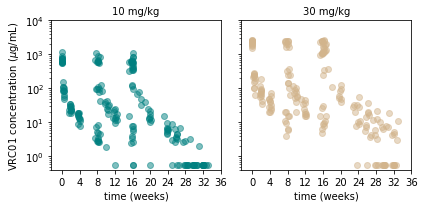

In [6]:
#plot all the patient data by cohort
fig,axarr=plt.subplots(1,2,sharey=True,figsize=(6,3))

c_list=['teal','tan']; var=[]
for i in range(len(cohort_names)):        
    ax=axarr[i]
    for j in range(len(tt[i])):
        ax.scatter(np.array(tt[i][j])/7,dd[i][j],alpha=0.5,color=c_list[i])
    
    ax.set_title(cohort_names[i],fontsize=10)
    ax.set_yscale('log')
    ax.set_ylim([0.4,1e4])
    ax.set_xlabel('time (weeks)')
    ax.set_xticks(range(0,40,4))
                    
axarr[0].set_ylabel('VRC01 concentration ($\mu$g/mL)')
fig.tight_layout()
fig.savefig('figures/PKraw.pdf',dpi=600)

In [7]:
#fit PK for each individual dose
PK_params=[[],[]] #list for optimal parameters 
for i in range(len(cohort_names)):        
    #ax=axarr[i]
    for j in range(len(tt[i])):
        if len(dd[i][j])>3: #make sure 4 data points for 4 free params!
            tfit=np.array(tt[i][j])-tt[i][j][0] #zero out
            pb0=dd[i][j][0],0.5,1e2,0.01 #initial guess of parameters
            pboundz=((0,0,0,0),(np.infty,5,np.infty,1))

            #fit the PK data, use that the variance is in absolute units and related to concentration
            popt,pcov=opt.curve_fit(bi_exp_fit,tfit,dd[i][j],pb0,ftol=1e-10,gtol=1e-10,
                                    sigma=np.array(dd[i][j]),absolute_sigma=True,
                                    bounds=pboundz)

            PK_params[i].append(popt)


In [8]:
#store the PK parameters
pd.DataFrame.to_csv(pd.DataFrame(PK_params[0]),'data/PK10.csv')
pd.DataFrame.to_csv(pd.DataFrame(PK_params[1]),'data/PK30.csv')

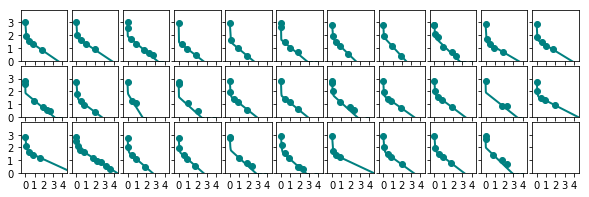

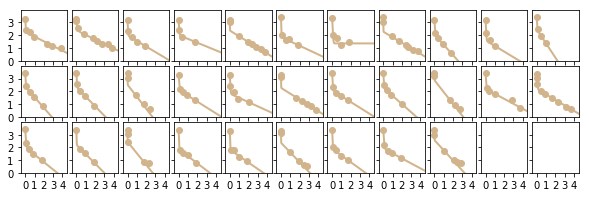

In [9]:
#plot all the fits! 
nx=3; ny=11

t_test=np.linspace(0,30*5,1e3)
for i in range(len(cohort_names)):        
    fig,axarr=plt.subplots(nx,ny,sharex=True,sharey=True,figsize=(10,3),
                           gridspec_kw={'wspace':0.1,'hspace':0.1})

    for j in range(len(tt[i])):
        if len(dd[i][j])>3: #make sure 4 data points for 4 free params!
        
            ax=axarr[int(j/ny)][j%ny] #go through the 6x6
            
            #plot data
            tfit=np.array(tt[i][j])-tt[i][j][0] #zero out
            ax.scatter(tfit/30, np.log10(dd[i][j]),color=c_list[i])
            
            #simulate the optimal parameter set and plot fit
            Y1,k1,Y2,k2=PK_params[i][j]
            conc_test = bi_exp_fit(t_test,Y1,k1,Y2,k2)
            ax.plot(t_test/30,np.log10(conc_test),lw=2,color=c_list[i])

    ax.set_ylim([0,4])
    ax.set_yticks(range(4))

    ax.set_xlim([-0.5,4.5])
    ax.set_xticks(range(5))
    
    #plt.tight_layout()
    plt.savefig('figures/PKfits'+cohort_names[i][:2]+'.pdf',dpi=600)

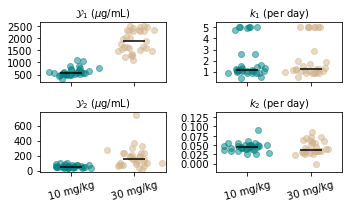

In [10]:
#plot each best fit parameter
plt.figure(figsize=(5,3))
param_names=['$\mathcal{Y}_1$ ($\mu$g/mL)','$k_1$ (per day)','$\mathcal{Y}_2$ ($\mu$g/mL)','$k_2$ (per day)']

for i in range(len(cohort_names)):        
    best_p = np.array(PK_params[i])        
    for j in range(len(param_names)):
        plt.subplot(221+j)
        plt.scatter(np.random.normal(i+1,0.15,len(best_p)),best_p[:,j],color=c_list[i],alpha=0.5)
        plt.scatter(i+1,np.median(best_p[:,j]),color='k',marker='_',s=500)
        plt.xlim([0.5,2.5])
        if j>1:
            plt.xticks([1,2],cohort_names,fontsize=10,rotation=15)
        else:
            plt.xticks([1,2],[])#,rotation=45)
        plt.title(param_names[j],fontsize=10)
        plt.locator_params(axis='y', nbins=7)

plt.tight_layout()
plt.savefig('figures/PKfits-paramvals.pdf',dpi=1000)

In [11]:
#put in the subtypes

assay_data=assay[assay.Antibody=='VRC01'].dropna()

assay_data['subtype']='x' #set all to x subtype

in_v=0
for v in assay_data['Virus']:#.iloc[0:100]:
    subtype=viruses[viruses['Virus name']==v]['Subtype']
    #print(subtype.values[0])
    assay_data['subtype'].iloc[in_v]=subtype.values[0]
    in_v+=1

/Applications/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [12]:
#see how many subtypes there are
subtype_list = np.unique(assay_data['subtype'])

/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in true_divide


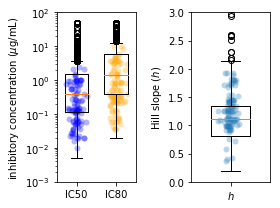

In [23]:
# IC50/80/h and dose response
jit=0.1 #for scatter jitter
plt.figure(figsize=(4,3))

#calculate hill slope
dic50=np.array(assay_data.IC50)
dic80=np.array(assay_data.IC80)
h=-np.log(4)/np.log(dic50/dic80)
h[np.isnan(h)]==np.nanmedian(h)
h[h<0]==np.nanmedian(h)

numic=100

plt.subplot(121)
plt.scatter(np.random.normal(0,jit,[numic]),dic50[:numic],alpha=0.3,lw=0,color='blue')
plt.scatter(np.random.normal(1,jit,[numic]),dic80[:numic],alpha=0.3,lw=0,color='orange')
plt.boxplot([dic50,dic80],positions=[0,1],widths=0.6)
plt.yscale('log')
plt.xticks([0,1],['IC50','IC80'])
plt.ylabel('inhibitory concentration ($\mu$g/mL)')
plt.ylim([0.001,100])

plt.subplot(122)
plt.scatter(np.random.normal(0,jit,[numic]),h[:numic],alpha=0.3,lw=0)
plt.boxplot(h.tolist(),positions=[0],widths=1)
plt.ylabel('Hill slope ($h$)')
plt.xticks([0],['$h$'])
plt.xlim([-1,1])
plt.ylim([0,3])

plt.tight_layout()
plt.savefig('figures/PD-stats.pdf')  # No warning now



In [24]:
#generate full PKPD variability
R0l=pd.DataFrame.from_csv('data/viral_dynamics.csv').iloc[:,0] #list from Robb fitting

num_curves=20

t=np.linspace(0,55,1e3) #simulate inhibitions over time
c=np.logspace(-4,4,1e3) #simulate dose response over concentration

#loop over 2 doses
pdtl=[[],[]]; Rtl=[[],[]]; pkl=[[],[]]; pdl=[[],[]]
for i in [0,1]:        
    #loop over number of PKPD curves
    for k in range(num_curves):
        
        randPKind=np.random.randint(0,len(PK_params[i])) #random PK index
        randPDind=np.random.randint(0,len(dic50)) #random PD index
        randR0ind=np.random.randint(0,len(R0l)) #random R0 index
        
        Y1,k1,Y2,k2=PK_params[i][randPKind][0:4] #pk values from list
        pk=bi_exp_fit(t,Y1,k1,Y2,k2) #simulate the pk fit
        pkl[i].append(pk)
                    
        pdc=1/(1+(dic50[randPDind]/c)**h[randPDind])
        pdl[i].append(pdc)
        
        pdt=1/(1+(dic50[randPDind]/pk)**h[randPDind]) #inhibition over time
        pdtl[i].append(pdt)

        R0=R0l[randR0ind]; #draw from a distribution or the Robb data        
        Rtl[i].append(R0*(1-pdt))



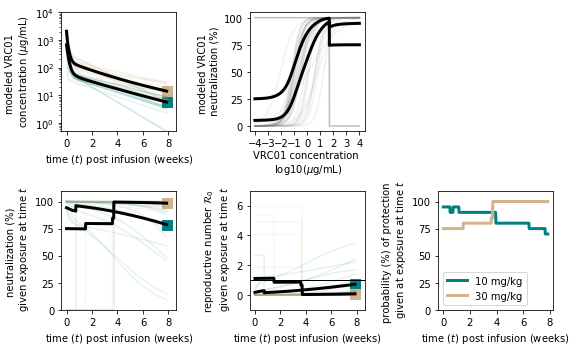

In [25]:
#plot theoretical curves drawing from all distributions
plt.figure(figsize=(8,5))

alz=0.1; lz='-'; sz=100 #styles for each line

#loop over 2 doses
for i in [0,1]:        
    #loop over number of PKPD curves
    for k in range(num_curves):

        #don't always plot these because will overplot
        if k<50:
            #plot PK
            plt.subplot(231)
            plt.semilogy(t/7,pkl[i][k],color=c_list[i],alpha=alz,ls=lz)
        
            #plot PD
            plt.subplot(232)
            plt.plot(np.log10(c),pdl[i][k]*100,color='gray',alpha=alz,ls=lz)

        #plot PDt
        plt.subplot(234)
        plt.plot(t/7,pdtl[i][k]*100,color=c_list[i],alpha=alz,ls=lz)

        plt.subplot(235)
        plt.plot(t/7,Rtl[i][k],color=c_list[i],alpha=alz,ls=lz)

    #calculate means and plot
        
for i in [0,1]:        
    plt.subplot(231)
    plt.semilogy(t/7,np.mean(pkl[i],0),color='k',lw=3,ls='-')
    plt.scatter(t[-1]/7,np.mean(pkl[i],0)[-1],c=c_list[i],s=sz,marker='s')
    plt.ylim([0,1e4])
    plt.xlabel('time ($t$) post infusion (weeks)')
    plt.ylabel('modeled VRC01 \n concentration ($\mu$g/mL)')
    plt.xticks(range(0,9,2))

    plt.subplot(232)
    plt.plot(np.log10(c),np.mean(pdl[i],0)*100,color='k',lw=3,ls='-')
    plt.xlabel('VRC01 concentration \n log10($\mu$g/mL)')
    plt.ylabel('modeled VRC01 \n neutralization (%)')
    plt.xticks(range(-4,5))
    #plt.xticks([1e-3,1e-2,1e-1,1,10,100,1e3,1e4])
    #plt.yticks(range(0,101,10))

    plt.subplot(234)
    plt.plot(t/7,np.mean(pdtl[i],0)*100,color='k',lw=3,ls='-')
    plt.scatter(t[-1]/7,np.mean(pdtl[i],0)[-1]*100,c=c_list[i],s=sz,marker='s')
    plt.ylim([0,110])
    plt.xlabel('time ($t$) post infusion (weeks)')
    plt.ylabel('neutralization (%) \n given exposure at time $t$')
    plt.xticks(range(0,9,2))
    
    plt.subplot(235)
    plt.plot(t/7,np.mean(Rtl[i],0),color='k',lw=3,ls='-')
    plt.scatter(t[-1]/7,np.mean(Rtl[i],0)[-1],c=c_list[i],s=sz,marker='s')
    plt.ylim([-1,7])
    plt.axhline(1,color='k',lw=1)
    plt.ylabel(r'reproductive number $\mathcal{R}_0$' +'\n given exposure at time $t$')#,fontsize=13)
    plt.xlabel('time ($t$) post infusion (weeks)')
    plt.xticks(range(0,9,2))

    plt.subplot(236)
    plt.plot(t/7,(1-np.sum(np.array(Rtl[i])>1,0)/num_curves)*100,color=c_list[i],lw=3)
    plt.xlabel('time ($t$) post infusion (weeks)')
    plt.ylabel('probability (%) of protection \n given at exposure at time $t$')
    plt.legend(cohort_names)
    plt.ylim([0,110])
    plt.xticks(range(0,9,2))

plt.tight_layout()
plt.savefig('figures/inhibition_R02.pdf',dpi=600)  # No warning now



In [ ]:
#note this is the total number of possible unique simulations
len(dic50)*len(PK_params[0])*len(R0l)

In [ ]:
len(dic50)*len(PK_params[0])

In [ ]:
# IC50/80/h by subtype
plt.figure(figsize=(7,7))
#loop over all subtypes for scatters
for i in range(len(subtype_list)):

    ad_st = assay_data[assay_data['subtype']==subtype_list[i]]
    
    plt.subplot(311)
    plt.scatter(np.random.normal(i,jit,[len(ad_st.IC50)]),ad_st.IC50,alpha=0.3,lw=0)
    plt.boxplot(ad_st.IC50.values,positions=[i],widths=0.6)
    plt.yscale('log')
    plt.ylabel('IC50 ($\mu$g/mL)')
    plt.xlim([-1,len(subtype_list)+1])
    plt.ylim([0.001,100])
    plt.xticks(range(len(subtype_list)),subtype_list,rotation=90)
    
    plt.subplot(312)
    plt.scatter(np.random.normal(i,jit,[len(ad_st.IC80)]),ad_st.IC80,alpha=0.3,lw=0)
    plt.boxplot(ad_st.IC80.values,positions=[i],widths=0.6)
    plt.yscale('log')
    plt.ylabel('IC80 ($\mu$g/mL)')
    plt.xlim([-1,len(subtype_list)+1])
    plt.ylim([0.001,100])
    plt.xticks(range(len(subtype_list)),subtype_list,rotation=90)

    plt.subplot(313)
    h=-np.log(4)/np.log(ad_st.IC50.values/ad_st.IC80.values)
    plt.scatter(np.random.normal(i,jit,[len(ad_st.IC50)]),h,alpha=0.3,lw=0)
    plt.boxplot(h,positions=[i],widths=1)
    plt.ylabel('Hill slope ($h$)')
    plt.xticks(range(len(subtype_list)),subtype_list,rotation=90)
    plt.xlim([-1,len(subtype_list)+1])
    plt.ylim([0,2])

plt.tight_layout()
plt.savefig('figures/PDstats_subtype.pdf',dpi=600)  # No warning now
